In [393]:
#!L
from catboost import CatBoostRegressor, monoforest, Pool, cv
from catboost.utils import create_cd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, lasso_path
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm as tqdm
from scipy import stats

In [394]:
#!L
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import warnings

In [418]:
#!L
warnings.filterwarnings('ignore')

In [396]:
#!L
%pip install seaborn

     |████████████████████████████████| 285 kB 3.4 MB/s 
     |████████████████████████████████| 11.6 MB 9.6 MB/s 
     |████████████████████████████████| 1.1 MB 12.5 MB/s 
     |████████████████████████████████| 14.8 MB 8.2 MB/s 
     |████████████████████████████████| 9.9 MB 18.8 MB/s 
     |████████████████████████████████| 2.2 MB 10.6 MB/s 
     |████████████████████████████████| 67 kB 6.1 MB/s 
     |████████████████████████████████| 227 kB 17.9 MB/s 
     |████████████████████████████████| 510 kB 21.9 MB/s 
     |████████████████████████████████| 27.4 MB 53 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mmdet 2.3.0rc0+c6b5ca2 requires Pillow<=6.2.2, but you have pillow 8.1.0 which is incompatible.
ml-kernel 0.0.1 requires setuptools<=50.3.2, but you have setuptools 51.1.1 which is incompatible.
You should consider upgrading via the '/usr/bin/python

In [397]:
#!L
PICKLE_DUMPS_PATH = os.path.join('resources', 'pickle_dumps')

def save_via_pickle(obj, filepath):
    with open(filepath, 'wb') as output_file:
        pickle.dump(obj, output_file)
        
def load_from_pickle(filepath):
    with open(filepath, 'rb') as input_file:
        return pickle.load(input_file)
    
def get_pickle_dump_path(dump_name):
    return os.path.join(PICKLE_DUMPS_PATH, f'{dump_name}.pkl')

In [398]:
#!L
catboost_main_argument_grid = {
#     'learning_rate': np.hstack([np.arange(0.001, 0.01, 0.001), 
#                                 np.arange(0.01, 0.1, 0.01), 
#                                 np.arange(0.1, 0.2, 0.01)]),
    'depth': range(1, 9),
#    'iterations': [2500]
}

# catboost_random_argument_grid = {
#     'learning_rate': np.arange(0.2, 1., 0.01),
#     'depth': range(1, 9),
# }

In [399]:
#!L
def train_catboost_reg(X_train, X_val, y_train, y_val, catboost_args, search_by_train_test_split=False):
    reg = CatBoostRegressor(**catboost_args)
    # random_args = reg.randomized_search(catboost_random_argument_grid, X_train, y_train, cv=3, verbose=False, plot=False, n_iter=200)
    # argument_grid = catboost_main_argument_grid.copy()
    # for best_key, best_value in random_args['params'].items():
    #     argument_grid[best_key] = np.hstack([argument_grid[best_key], [best_value]])
    best_args = reg.grid_search(catboost_main_argument_grid, X_train, y_train, cv=3, verbose=False, plot=False, search_by_train_test_split=search_by_train_test_split)
    # reg = CatBoostRegressor(**catboost_args)
    # reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, metric_period=10000)
    print(reg.get_params(), best_args['params'])
    return reg

In [400]:
#!L
def transform_X_catboost(X, monomials):
    X_out = np.ones((X.shape[0], len(monomials)), dtype=np.bool)
    for i, x in enumerate(X):
        for j, monomial in enumerate(monomials):
            for split in monomial.splits:
                X_out[i, j] = X_out[i, j] and np.less_equal(split.border, x[split.feature_idx])
    return X_out

In [452]:
#!L
# def _train_lasso(max_iter, lambda_arg, X, y):
#     return Lasso(max_iter=max_iter, alpha=lambda_arg).fit(X, y)

# def _select_lasso_iter(X_train, X_val, y_train, y_val, lambda_arg, max_iter=2000, iter_step=1):
#     best_score = None
#     best_iter = None
#     for cur_iter in range(1, max_iter + 1, iter_step):
#         lasso = _train_lasso(cur_iter, lambda_arg, X_train, y_train)
#         cur_score = mean_squared_error(y_val, lasso.predict(X_val), squared=False)
#         if best_score is None or cur_score < best_score:
#             best_score = cur_score
#             best_iter = cur_iter
    
#     return best_score, best_iter

def _select_best_lasso_iter(X_train, X_val, y_train, y_val, lambda_arg, max_iter=5000, select_best_iteration=True):
    best_score = None
    best_iter = None
    big_lasso = Lasso(alpha=lambda_arg, max_iter=max_iter).fit(X_train, y_train)
    if not select_best_iteration:
        return mean_squared_error(y_val, big_lasso.predict(X_val), squared=False), max_iter
    lasso = Lasso(alpha=lambda_arg, max_iter=1, warm_start=True)
    for cur_iter in range(1, big_lasso.n_iter_ + 1):
        lasso.fit(X_train, y_train)
        # assert np.allclose(lasso.coef_, Lasso(alpha=lambda_arg, max_iter=cur_iter).fit(X_train, y_train).coef_)
        val_score = mean_squared_error(y_val, lasso.predict(X_val), squared=False)
        if best_score is None or val_score < best_score:
            best_score = val_score
            best_iter = cur_iter
    return best_score, best_iter

def train_best_lasso(X_train, X_val, y_train, y_val, lambda_max=1000, lambda_min=1e-4, decay=0.9,
                     max_iter=5000, iter_step=1, verbose=True, max_lambda_checks=None, without_improvements_filter=None,
                     select_best_iteration=True):
    best_score = None
    best_lambda = None
    best_iter = None
    iter_number = 0
    iter_lim = max_lambda_checks if max_lambda_checks else np.inf
    cur_lambda = lambda_max
    last_imporvment = None
    while np.less(lambda_min, cur_lambda) and iter_number < iter_lim:
        cur_score, cur_iter = _select_best_lasso_iter(X_train, X_val, y_train, y_val, cur_lambda, max_iter, select_best_iteration=select_best_iteration)
        if best_score is None or cur_score < best_score:
            best_score = cur_score
            best_iter = cur_iter
            best_lambda = cur_lambda
            last_imporvment = iter_number
            print(f'New best score: lambda={cur_lambda}, n_iter={cur_iter}, rmse={cur_score}')
        cur_lambda *= decay
        iter_number += 1
        if verbose and iter_number % 10 == 0:
            print(f'Iter {iter_number}(lambda={cur_lambda}), best: lambda={best_lambda}, n_iter={best_iter}, rmse={best_score}')
        if without_improvements_filter is not None:
            if (last_imporvment is None and iter_number >= without_improvements_filter) or (
                last_imporvment is not None and iter_number - last_imporvment >= without_improvements_filter):
                break
    
    return Lasso(alpha=best_lambda, max_iter = best_iter).fit(X_train, y_train)

In [402]:
#!L
def get_lasso_and_boosting_difference(X_train, X_val, X_test, y_train, y_val, y_test, catboost_args,
                                      lambda_max=1000, lambda_min=1e-4, decay=0.9, max_iter=5000, iter_step=1):
    reg = train_catboost_reg(X_train, X_val, y_train, y_val, catboost_args)
    catboost_monomials = monoforest.to_polynom(catboost_reg)
    X_train_mon = transform_X_catboost(X_train, catboost_monomials)
    X_val_mon = transform_X_catboost(X_val, catboost_monomials)
    X_test_mon = transform_X_catboost(X_test, catboost_monomials)
    lasso = train_lasso(X_train_mon, X_val_mon, y_train, y_val, 
                        lambda_max=lambda_max, lambda_min=lambda_min, decay=decay, max_iter=max_iter, iter_step=iter_step)
    return mean_squared_error(y_test, reg.predict(X_test), squared=False) - mean_squared_error(y_test, lasso.predict(X_test_mon), squared=False)

In [403]:
#!L
diabetes = load_diabetes()
X, y = diabetes['data'], diabetes['target']

In [257]:
#!L
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [258]:
#!L
n_iter = 16
test_lasso_2 = Lasso(alpha=0.1, max_iter=n_iter).fit(X_train, y_train)
print(test_lasso_2.n_iter_)
test_lasso_2_coef = test_lasso_2.coef_
lasso = Lasso(alpha=0.1, max_iter=1, warm_start=True)
test_lasso_coef = None
# print(f'Coef: {test_lasso_2_coef}')
for _ in range(n_iter):
    lasso.fit(X_train, y_train)
    # print(f'Current coef: {test_lasso_coef}')
print(np.max(lasso.coef_ - test_lasso_2_coef))

13
0.010667572160912187


In [ ]:
#!L
train_best_lasso(X_train, X_val, y_train, y_val)

In [ ]:
#!L
reg = train_catboost_reg(X_train, X_val, y_train, y_val, {})

In [ ]:
#!L
train_best_lasso(X_train, X_val, y_train, y_val)

In [ ]:
# !L
test_data = Pool(data=X_train,
                 label=y_train)

test_reg = CatBoostRegressor(verbose=True)
best_args = test_reg.grid_search(catboost_main_argument_grid, X_train, y_train, verbose=True, plot=False)

# scores = cv(test_data,
#             { "iterations": 1000,
#               "depth": 2,
#               "loss_function": "RMSE",
#               "verbose": False,
#               "use_best_model": True,
#               "eval_set": (X_val, y_val) },
#             fold_count=3)
# for depth in range(1, 10):
#     test_reg = CatBoostRegressor(depth = depth, iterations=5000)
#     test_reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, metric_period=10000)

In [270]:
#!L
rng = np.random.default_rng()

In [271]:
#!L
def generate_train_val_test_split(total_size, val_percent, test_percent, rng):
    ids = rng.permutation(total_size)
    first_border = round(total_size * (1 - val_percent - test_percent))
    second_border = first_border + round(total_size * val_percent)
    return ids[:first_border], ids[first_border:second_border], ids[second_border:]

In [273]:
#!L
splits = [generate_train_val_test_split(X.shape[0], 0.2, 0.2, rng) for _ in range(1000)]

In [279]:
#!L
save_via_pickle(splits, get_pickle_dump_path('diabetes_splits'))

In [462]:
#!L
def build_differences(X, y, catboost_reg_config, splits, dump_titile, splits_to_proceed=None, 
                      val_percent=0.2, test_percent=0.2, select_best_iteration=True):
    if splits_to_proceed is None:
        splits_to_proceed = len(splits)
    catboost_reg_config.update({ 'verbose' : False, 'iterations' : 5000 })
#     reg = CatBoostRegressor(**catboost_reg_config)
#     best_depth = reg.grid_search({ 'depth' : range(1, 9) }, X, y, verbose=True, plot=False, cv=5)['params']['depth']
    best_depth = 1
    print(f'Selected depth: {best_depth}')
    catboost_reg_config.update({ 'depth' : best_depth })
    diffs = []
    for iter_ind, split in tqdm(enumerate(splits[:splits_to_proceed])):
        reg = CatBoostRegressor(**catboost_reg_config)
        X_train, X_val, X_test, y_train, y_val, y_test = X[split[0]], X[split[1]], X[split[2]], y[split[0]], y[split[1]], y[split[2]]
        reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, metric_period=10000, verbose=False)
        monomials = monoforest.to_polynom(reg)
        X_train_mon = transform_X_catboost(X_train, monomials)
        X_val_mon = transform_X_catboost(X_val, monomials)
        X_test_mon = transform_X_catboost(X_test, monomials)
        lasso = train_best_lasso(X_train_mon, X_val_mon, y_train, y_val, verbose=False,
                                 lambda_max=100, lambda_min=1e-1, decay=0.6,
                                 without_improvements_filter=15, max_iter=2000, select_best_iteration=select_best_iteration)
        diffs.append(mean_squared_error(y_test, reg.predict(X_test), squared=False) - mean_squared_error(y_test, lasso.predict(X_test_mon), squared=False))
        if iter_ind % 20 == 0:
            print(f'Iter: {iter_ind}, diff: {diffs[-1]}')
            save_via_pickle(diffs, get_pickle_dump_path(f'{dump_titile}_{iter_ind}'))
    return diffs

In [360]:
#!L
diffs = build_differences(X, y, {}, splits)

TypeError: build_differences() missing 1 required positional argument: 'dump_titile'

In [ ]:
#!L
save_via_pickle(diffs, get_pickle_dump_path('diabetes_empty_argset_diffs'))

In [328]:
#!L
empty_argset_diffs = load_from_pickle(get_pickle_dump_path('diabetes_empty_argset_diffs_240'))

<AxesSubplot:xlabel='rmse', ylabel='Density'>

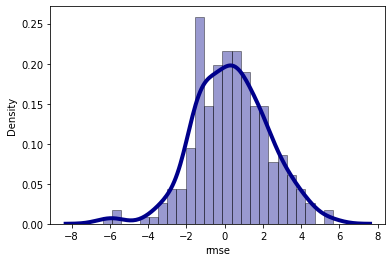

In [329]:
#!L
sns.distplot(empty_argset_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse')

In [ ]:
#!L
default_argset_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                 'bootstrap_type': 'No',
                                                 'score_function': 'L2',
                                                 'leaf_estimation_method': None }, splits, 'default_argset_diffs')

In [336]:
#!L
default_argset_diffs = load_from_pickle(get_pickle_dump_path('default_argset_diffs_240'))

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse', ylabel='Density'>

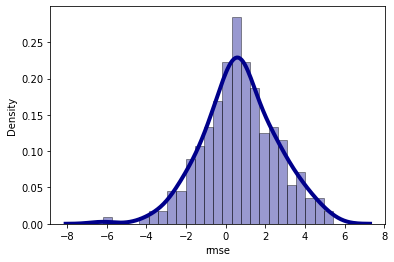

In [338]:
#!L
sns.distplot(default_argset_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse')

In [355]:
#!L
warnings.filterwarnings('ignore')

In [366]:
#!L
bootstrap_argset_diffs = build_differences(X, y, { 'boosting_type' : 'Plain', 
                                                   'bootstrap_type' : 'Poisson', 
                                                   'iterations' : 5000,
                                                   'task_type' : 'GPU',
                                                   'score_function' : 'L2', 
                                                   'leaf_estimation_method': None }, splits, 'bootstrap_argset_diffs')

Selected depth: 3


0it [00:03, ?it/s]


KeyboardInterrupt: 

In [370]:
#!L
bootstrap_argset_diffs = load_from_pickle(get_pickle_dump_path('diabetes_bootstrap_argset_diffs_240'))

<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

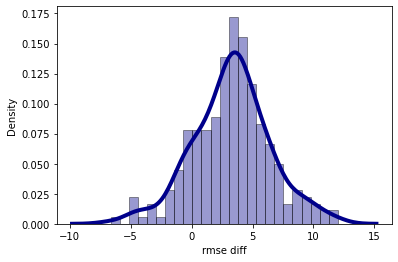

In [372]:
#!L
sns.distplot(bootstrap_argset_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [ ]:
#!L
build_differences(X, y, { 'boosting_type': 'Plain',
                          'bootstrap_type': 'No',
                          'score_function': 'NewtonL2',
                          'leaf_estimation_method': None }, splits, 'diabetes_LightGBM_argset_diffs')

<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

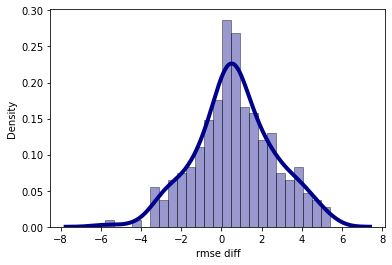

In [376]:
#!L
sns.distplot(load_from_pickle(get_pickle_dump_path('diabetes_LightGBM_argset_diffs_240')), hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [380]:
#!L
diffs1 = load_from_pickle(get_pickle_dump_path('diabetes_bootstrap_argset_diffs_240'))
diffs2 = load_from_pickle(get_pickle_dump_path('diabetes_LightGBM_argset_diffs_240'))
diffs3 = load_from_pickle(get_pickle_dump_path('diabetes_empty_argset_diffs_240'))
diffs4 = load_from_pickle(get_pickle_dump_path('diabetes_default_argset_diffs_240'))

In [387]:
#!L
from scipy.stats import pearsonr
for i, diff1 in enumerate([diffs1, diffs2, diffs3, diffs4]):
    for j, diff2 in enumerate([diffs1, diffs2, diffs3, diffs4]):
        print(f'{i} - {j}: {pearsonr(diff1, diff2)[0]}')

0 - 0: 1.0
0 - 1: 0.23470221625047263
0 - 2: 0.15576467121392362
0 - 3: 0.24665794333884475
1 - 0: 0.23470221625047263
1 - 1: 1.0
1 - 2: 0.5367101088393159
1 - 3: 0.9356942731898966
2 - 0: 0.15576467121392362
2 - 1: 0.5367101088393159
2 - 2: 1.0
2 - 3: 0.5385846287937043
3 - 0: 0.24665794333884475
3 - 1: 0.9356942731898966
3 - 2: 0.5385846287937043
3 - 3: 1.0


In [411]:
#!L
# default_argset_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
#                                                  'bootstrap_type': 'No',
#                                                  'score_function': 'L2',
#                                                  'grow_policy': 'Depthwise',
#                                                  'leaf_estimation_method': None }, splits, 'depthwise_trees_argset_diffs')

Selected depth: 1


0it [00:00, ?it/s]

[0;31mKernelNotResponding[0m: Kernel died unexpectedly and has been restarted. If it's not coming back, please, try restarting from the main menu.

In [413]:
#!L
# reg = CatBoostRegressor(**{ 'boosting_type': 'Plain',
#                             'bootstrap_type': 'No',
#                             'score_function': 'L2',
#                             'grow_policy': 'Depthwise',
#                             'leaf_estimation_method': None,
#                             'depth' : 1})

In [ ]:
#!L
border_count_32_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 32,
                                                  'leaf_estimation_method': None }, splits, 'diabetes_border_count_32_argset_diffs')

<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

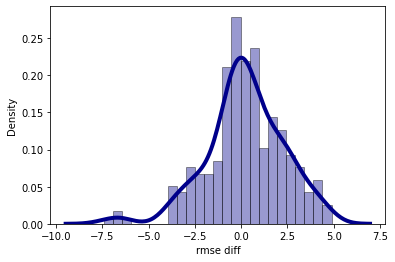

In [422]:
#!L
sns.distplot(load_from_pickle(get_pickle_dump_path('diabetes_border_count_32_argset_diffs_240')), hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [ ]:
#!L
border_count_64_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 64,
                                                  'leaf_estimation_method': None }, splits, 'diabetes_border_count_64_argset_diffs')

<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

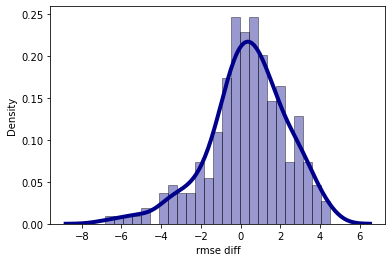

In [429]:
#!L
sns.distplot(load_from_pickle(get_pickle_dump_path('diabetes_border_count_64_argset_diffs_240')), hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [ ]:
#!L
border_count_96_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 96,
                                                  'leaf_estimation_method': None }, splits, 'diabetes_border_count_96_argset_diffs', 260)

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

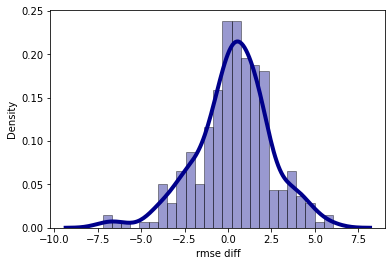

In [442]:
#!L
sns.distplot(border_count_96_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [ ]:
#!L
border_count_128_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 128,
                                                  'leaf_estimation_method': None }, splits, 'diabetes_border_count_128_argset_diffs', 260)

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

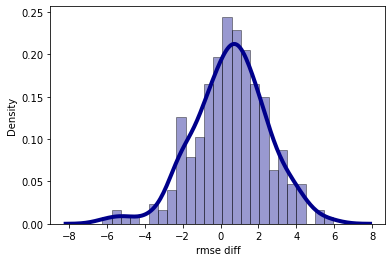

In [443]:
#!L
sns.distplot(border_count_128_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [436]:
#!L
border_count_160_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 160,
                                                  'leaf_estimation_method': None }, splits, 'diabetes_border_count_160_argset_diffs', 260)


bestTest = 47.47291808
bestIteration = 1351

0:	loss: 47.4729181	best: 47.4729181 (0)	total: 722ms	remaining: 5.05s

bestTest = 48.59663137
bestIteration = 318

1:	loss: 48.5966314	best: 47.4729181 (0)	total: 1.74s	remaining: 5.23s

bestTest = 48.9310109
bestIteration = 263

2:	loss: 48.9310109	best: 47.4729181 (0)	total: 3.87s	remaining: 6.45s

bestTest = 48.79899455
bestIteration = 380

3:	loss: 48.7989946	best: 47.4729181 (0)	total: 5.87s	remaining: 5.87s

bestTest = 49.72615773
bestIteration = 187

4:	loss: 49.7261577	best: 47.4729181 (0)	total: 8.68s	remaining: 5.21s

bestTest = 51.92879622
bestIteration = 174

5:	loss: 51.9287962	best: 47.4729181 (0)	total: 12.8s	remaining: 4.28s

bestTest = 51.65699851
bestIteration = 174

6:	loss: 51.6569985	best: 47.4729181 (0)	total: 19.5s	remaining: 2.79s

bestTest = 51.87083093
bestIteration = 228

7:	loss: 51.8708309	best: 47.4729181 (0)	total: 28.9s	remaining: 0us
Estimating final quality...
Selected depth: 1
New best score: lambda=100, 

260it [36:52,  8.51s/it]


/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

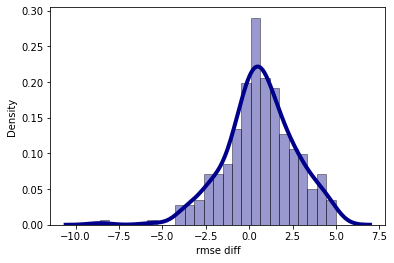

In [444]:
#!L
sns.distplot(border_count_160_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [437]:
#!L
border_count_192_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 192,
                                                  'leaf_estimation_method': None }, splits, 'diabetes_border_count_192_argset_diffs', 260)


bestTest = 47.52244495
bestIteration = 1607

0:	loss: 47.5224449	best: 47.5224449 (0)	total: 742ms	remaining: 5.2s

bestTest = 48.37139483
bestIteration = 307

1:	loss: 48.3713948	best: 47.5224449 (0)	total: 1.87s	remaining: 5.6s

bestTest = 48.50344387
bestIteration = 707

2:	loss: 48.5034439	best: 47.5224449 (0)	total: 3.38s	remaining: 5.63s

bestTest = 48.13862055
bestIteration = 431

3:	loss: 48.1386206	best: 47.5224449 (0)	total: 5.35s	remaining: 5.35s

bestTest = 49.92102141
bestIteration = 170

4:	loss: 49.9210214	best: 47.5224449 (0)	total: 8.4s	remaining: 5.04s

bestTest = 50.80000085
bestIteration = 181

5:	loss: 50.8000008	best: 47.5224449 (0)	total: 12.4s	remaining: 4.13s

bestTest = 51.79159266
bestIteration = 166

6:	loss: 51.7915927	best: 47.5224449 (0)	total: 19.2s	remaining: 2.74s

bestTest = 51.99573854
bestIteration = 228

7:	loss: 51.9957385	best: 47.5224449 (0)	total: 29.4s	remaining: 0us
Estimating final quality...
Selected depth: 1
New best score: lambda=100, n_

260it [37:03,  8.55s/it]


/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

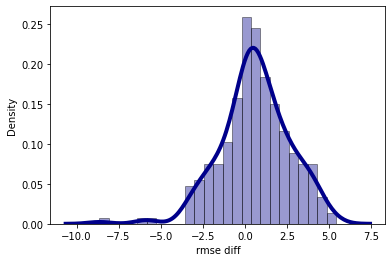

In [445]:
#!L
sns.distplot(border_count_192_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [438]:
#!L
border_count_224_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 224,
                                                  'leaf_estimation_method': None }, splits, 'diabetes_border_count_224_argset_diffs', 260)


bestTest = 47.62819728
bestIteration = 1247

0:	loss: 47.6281973	best: 47.6281973 (0)	total: 740ms	remaining: 5.18s

bestTest = 48.43689508
bestIteration = 313

1:	loss: 48.4368951	best: 47.6281973 (0)	total: 1.85s	remaining: 5.56s

bestTest = 48.82632568
bestIteration = 274

2:	loss: 48.8263257	best: 47.6281973 (0)	total: 3.43s	remaining: 5.72s

bestTest = 47.79047928
bestIteration = 484

3:	loss: 47.7904793	best: 47.6281973 (0)	total: 5.53s	remaining: 5.53s

bestTest = 49.98414746
bestIteration = 169

4:	loss: 49.9841475	best: 47.6281973 (0)	total: 8.35s	remaining: 5.01s

bestTest = 51.6449382
bestIteration = 167

5:	loss: 51.6449382	best: 47.6281973 (0)	total: 12.7s	remaining: 4.23s

bestTest = 52.13431537
bestIteration = 175

6:	loss: 52.1343154	best: 47.6281973 (0)	total: 20s	remaining: 2.86s

bestTest = 52.63984997
bestIteration = 184

7:	loss: 52.6398500	best: 47.6281973 (0)	total: 31s	remaining: 0us
Estimating final quality...
Selected depth: 1
New best score: lambda=100, n_it

260it [37:14,  8.59s/it]


/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

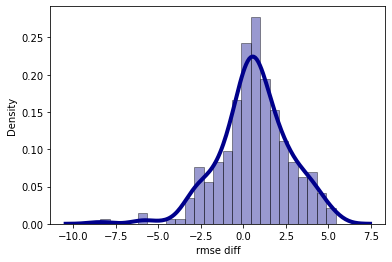

In [446]:
#!L
sns.distplot(border_count_224_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [439]:
#!L
border_count_255_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 255,
                                                  'leaf_estimation_method': None }, splits, 'diabetes_border_count_255_argset_diffs', 260)


bestTest = 47.62819728
bestIteration = 1247

0:	loss: 47.6281973	best: 47.6281973 (0)	total: 759ms	remaining: 5.31s

bestTest = 48.43730785
bestIteration = 313

1:	loss: 48.4373078	best: 47.6281973 (0)	total: 1.94s	remaining: 5.83s

bestTest = 48.29833316
bestIteration = 690

2:	loss: 48.2983332	best: 47.6281973 (0)	total: 3.49s	remaining: 5.82s

bestTest = 47.9295885
bestIteration = 524

3:	loss: 47.9295885	best: 47.6281973 (0)	total: 5.58s	remaining: 5.58s

bestTest = 49.9954344
bestIteration = 162

4:	loss: 49.9954344	best: 47.6281973 (0)	total: 8.44s	remaining: 5.06s

bestTest = 51.20443466
bestIteration = 193

5:	loss: 51.2044347	best: 47.6281973 (0)	total: 14.8s	remaining: 4.92s

bestTest = 51.62496307
bestIteration = 212

6:	loss: 51.6249631	best: 47.6281973 (0)	total: 22.4s	remaining: 3.2s

bestTest = 52.67745618
bestIteration = 182

7:	loss: 52.6774562	best: 47.6281973 (0)	total: 34.2s	remaining: 0us
Estimating final quality...
Selected depth: 1
New best score: lambda=100, n_

260it [37:02,  8.55s/it]


/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

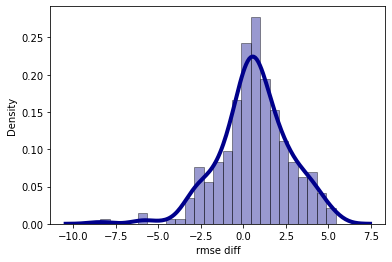

In [447]:
#!L
sns.distplot(border_count_255_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [458]:
#!L
warnings.filterwarnings('ignore')

In [463]:
#!L
default_without_best_iteration_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                                 'bootstrap_type': 'No',
                                                                 'score_function': 'L2',
                                                                 'leaf_estimation_method': None }, splits, 'default_without_best_iteration_diffs', 260, select_best_iteration=False)

Selected depth: 1
New best score: lambda=100, n_iter=2000, rmse=73.55835347465174
New best score: lambda=12.959999999999999, n_iter=2000, rmse=64.39847098257444
New best score: lambda=7.775999999999999, n_iter=2000, rmse=59.77149531996321
New best score: lambda=4.6655999999999995, n_iter=2000, rmse=58.80827273201162
Iter: 0, diff: -0.11043645030620297
New best score: lambda=100, n_iter=2000, rmse=76.31655346363198
New best score: lambda=21.599999999999998, n_iter=2000, rmse=75.9401051399955
New best score: lambda=12.959999999999999, n_iter=2000, rmse=66.54027859046556
New best score: lambda=7.775999999999999, n_iter=2000, rmse=63.12060824384524
New best score: lambda=4.6655999999999995, n_iter=2000, rmse=61.08029158008063
New best score: lambda=2.7993599999999996, n_iter=2000, rmse=60.52724415909046
New best score: lambda=1.6796159999999998, n_iter=2000, rmse=60.29752495725535
New best score: lambda=100, n_iter=2000, rmse=79.85647854092237
New best score: lambda=12.959999999999999, n_i

260it [27:37,  6.38s/it]


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

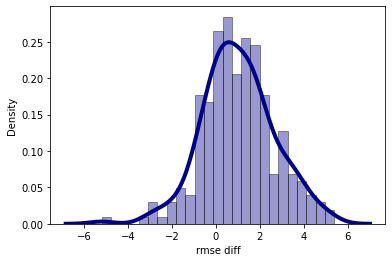

In [464]:
#!L
sns.distplot(load_from_pickle(get_pickle_dump_path('default_without_best_iteration_diffs_240')), hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')